# Read SUMMA output

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph
import matplotlib.gridspec as gridspec

# Offline Turbulence Package
import turbpy

# Customize
sns.set_style("whitegrid")
sns.set_context('paper', font_scale=1.5)
%matplotlib inline

In [2]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/'

dirProj = dirPre + 'SnowHydrology/proj/ModTsfc/'
dirPrint = dirProj + 'Graphics'
dirData = dirProj + 'data'

## Functions to quickly evaluate all model output

In [3]:
def evalBiasTs(ax, dsDict, obs, labels, ls, lcolor):
    # Tsurf scatter plot
    hours = np.arange(0, 24)
    for ex in sorted(dsDict.keys()):
        ax.plot(dsDict[ex].scalarSurfaceTemp - 273.15, obs.Tsrf, '.',
                label=labels[ex],
                color=lcolor[ex])
    ax.plot([-30, 0], [-30, 0], 'k--')
    ax.set_xlim(-30, 0)
    ax.set_ylim(-30, 0)
    ax.set_xlabel('Modeled T ($^{\circ}$)')
    ax.set_ylabel('Observed T ($^{\circ}$)')
    ax.legend(loc='best')

def sortFun(s):
    if 'high' in s and 'L' in s:
        return(4)
    elif 'high' in s and 'S' in s:
        return(3)
    elif 'low' in s and 'S' in s:
        return(2)
    elif 'low' in s and 'L' in s:
        return(1)
    

## Grab data: observations and model output

In [4]:
# ----------
# Sites and forcing data
siteNames = ['SWA', 'CDP']
siteYears = {'SWA': np.arange(2006, 2012),
             'CDP': np.arange(2002, 2010)}

d1 = {'CDP': datetime(2002, 10, 1), 'SWA': datetime(2006, 10, 1)}
d2 = {'CDP': datetime(2010, 9, 30, 22, 0, 0), 'SWA': datetime(2012, 9, 30, 23, 0, 0)}

os.chdir(dirData)
CDPforce = xr.open_dataset('CDP.ModTsfc.nc')
CDPforce = CDPforce.loc[dict(time = slice(d1['CDP'], d2['CDP']))]
CDPforce_daily = CDPforce.resample(how='mean', freq='d', dim='time')

SWAforce = xr.open_dataset('SWA.ModTsfc.nc')
SWAforce = SWAforce.loc[dict(time = slice(d1['SWA'], d2['SWA']))]
SWAforce_daily = SWAforce.resample(how='mean', freq='d', dim='time')

# ----------
# Summa modeling results for each site
os.chdir(dirData  + '/summaResults')

SWA = xr.open_dataset('SWA.summaResults.forcing.nc')
SWA = xr.concat([SWA, xr.open_dataset('SWA.summaResults.internal.nc')], 'expID')
print(SWA)

CDP = xr.open_dataset('CDP.summaResults.forcing.nc')
CDP = xr.concat([CDP, xr.open_dataset('CDP.summaResults.internal.nc')], 'expID')
print(CDP)

<xarray.Dataset>
Dimensions:                (expID: 45, time: 52608)
Coordinates:
  * time                   (time) datetime64[ns] 2006-10-01 ...
    exp                    (expID) object 'longwaveBias' 'longwaveBias' ...
    family                 (expID) object 'lowLW' 'lowLW' 'highLW' 'highLW' ...
  * expID                  (expID) object 'lowLW_L' 'lowLW_S' 'highLW_S' ...
Data variables:
    scalarRainPlusMelt     (expID, time) float64 -9.999e+03 -9.999e+03 ...
    scalarSWE              (expID, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    scalarSnowSublimation  (expID, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    scalarInfiltration     (expID, time) float64 1.784e-07 3.584e-09 0.0 0.0 ...
    scalarSurfaceRunoff    (expID, time) float64 3.338e-12 7.387e-14 0.0 0.0 ...
    scalarSurfaceTemp      (expID, time) float64 283.1 280.9 279.7 278.8 ...
    scalarSenHeatTotal     (expID, time) float64 -75.53 -20.79 -19.85 -15.34 ...
    scalarLatHeatTotal     (expID, time) float64

In [5]:
# ----------
# Experiment names - Structure Uncertainty
experiments = ['longwaveBias', 'shortwaveBias', 'specHumidBias',
               'airTempBias', 'windBias', 'layers',
               'thermalCond', 'stability']
expMetUnc = ['longwaveBias', 'shortwaveBias', 'specHumidBias',
               'airTempBias', 'windBias']
expIntern = ['layers', 'thermalCond', 'stability']
experimentType = {'forcing': expMetUnc, 'internal': expIntern}
force = {'SWA': SWAforce, 'CDP': CDPforce}
results = {'SWA': SWA, 'CDP': CDP}

# ----------
# Met uncertainty experiment IDs and values
expNames = {'longwaveBias': ['lowLW_L','lowLW_S', 'highLW_S', 'highLW_L']}
expBias = {'longwaveBias': {'lowLW_L': -25, 'lowLW_S': -10, 'highLW_S': 10, 'highLW_L': 25}}

expNames['shortwaveBias'] = ['lowSW_L','lowSW_S', 'highSW_S', 'highSW_L']
expBias['shortwaveBias'] = {'lowSW_L': -80, 'lowSW_S': -30, 'highSW_S': 30, 'highSW_L': 80}

expNames['specHumidBias'] = ['lowQS_L','lowQS_S', 'highQS_S', 'highQS_L']
expBias['specHumidBias'] = {'lowQS_L': -25,  'lowQS_S': -10, 'highQS_S': 10, 'highQS_L': 25}

expNames['airTempBias'] = ['lowTair_L','lowTair_S', 'highTair_S', 'highTair_L']
expBias['airTempBias'] = {'lowTair_L': -3, 'lowTair_S': -1.5, 'highTair_S': 1.5, 'highTair_L': 3}

expNames['windBias'] = ['lowU_L','lowU_S', 'highU_S', 'highU_L']
expBias['windBias'] = {'lowU_L': -3, 'lowU_S': -1.5, 'highU_S': 1.5, 'highU_L': 3}

metName = {'longwaveBias': 'LWRadAtm',
           'shortwaveBias': 'SWRadAtm',
           'specHumidBias': 'spechum',
           'airTempBias': 'airtemp',
           'windBias': 'windspd'}

metNameTitle = {'longwaveBias': 'Longwave Bias (Wm$^{-2}$)',
           'shortwaveBias': 'Shortwave Bias (Wm$^{-2}$)',
           'specHumidBias': 'Relative Humiditiy Bias (%)',
           'airTempBias': 'Air Temperature Bias ($^{\circ}$C)',
           'windBias': 'Wind Speed Bias (m s$^{-1}$)'}

# ----------
# Layer
expNames['layers'] = ['layerThin', 'layerThick', 'jrdn1991', 'CLM_2010']

# Thermal conductivity
arrayNames = ['tyen1965', 'melr1977', 'jrdn1991', 'smnv2000']
arrayAppend = ['Mid', 'Low', 'High']
expNames['thermalCond'] = [name + '_' + append for name in arrayNames for append in arrayAppend]

# Stability
arrayAppend = ['Low', 'Mid', 'High']
arrayNames = ['standard', 'louisinv', 'mahrtexp']
expNames['stability'] = [name + '_' + append for name in arrayNames for append in arrayAppend]

internalNames = {'stability': ['standard', 'louisinv', 'mahrtexp'],
                 'layers': ['layerThin', 'layerThick', 'jrdn1991', 'CLM_2010'],
                 'thermalCond': ['tyen1965', 'melr1977', 'jrdn1991', 'smnv2000']}
internalLabels = {'layers': {'layerThin': 'UEB', 'layerThick': 'VIC', 'jrdn1991': 'SNTHERM', 'CLM_2010': 'CLM'},
                  'stability': {'standard': 'Anderson', 'louisinv': 'Louis', 'mahrtexp': 'Mahrt'},
                  'thermalCond': {'tyen1965': 'Yen', 'melr1977': 'Mellor',
                                  'jrdn1991': 'Jordan', 'smnv2000': 'Smirnova'}}
internalTitles = {'layers': 'a) Vertical Structure',
                  'stability': 'b) Stability Correction',
                  'thermalCond': 'c) Thermal Conductivity'}

# ----------
# Scalar variables to extract from output
scalar_data_vars = ['scalarRainPlusMelt', 'scalarSWE', 'scalarSnowSublimation', 
                    'scalarInfiltration', 'scalarSurfaceRunoff', 'scalarSurfaceTemp',
                    'scalarSenHeatTotal', 'scalarLatHeatTotal', 'scalarSnowDepth']

## Assign colors/line types for each experiment

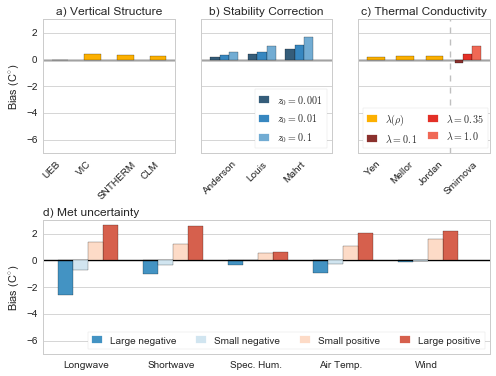

In [15]:
sns.set_context('paper', font_scale=1.25)

# ----------
# Biases
flag_modelRelative = False
s = 'CDP'
ylims = [-7, 3]

# Bias relative to model with no errors
if flag_modelRelative:
    noBias = results[s].sel(expID='jrdn1991')
    ds = ((results[s].scalarSurfaceTemp) - noBias.scalarSurfaceTemp)
    ds = ds.where((results[s].scalarSWE > 0) & (noBias.scalarSWE > 0))
# Bias relative to observations
else:
    ds = ((results[s].scalarSurfaceTemp - 273.15) - force[s].Tsrf)
    ds = ds.where((force[s].SP) & (results[s].scalarSWE > 0))

# Figure
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 3, hspace=0.5)    
width = 0.175

# ----------
# Met Uncertainty
ax = plt.subplot(gs[1, :])
zorder = [1, 2, 4, 3]
ax_x_label = ['Longwave', 'Shortwave', 'Spec. Hum.',
              'Air Temp.', 'Wind']
for n, exp in enumerate(expMetUnc):
    for nameNum, names in enumerate(sorted(expNames[exp], key=sortFun)):
        xpos = ((nameNum + 1) * width) + n
        ax.bar(xpos, np.mean(ds.sel(expID=names)),
               width=width, color=sns.color_palette('RdBu_r', 4)[nameNum], zorder=zorder[nameNum])
ax.set_ylabel('Bias (C$^{\circ}$)')
ax.set_xticks(np.arange(0, len(expNames[exp]) + 1) + 0.5)
ax.set_xticklabels(ax_x_label)
ax.set_xlim(0, 5.25)
ax.xaxis.grid(False)
ax.plot([0, 6], [0, 0], 'k', zorder=1)
ax.set_ylim(ylims)
ax.set_title('d) Met uncertainty', loc='left')

# ----------
# Structural Uncertainty
n = 0
exp = 'layers'
arrayLayers = ['layerThin', 'layerThick', 'jrdn1991', 'CLM_2010']
xlabels = ['UEB', 'VIC','SNTHERM', 'CLM']
ax = plt.subplot(gs[0, n])
width = 0.5
for nameNum, names in enumerate(arrayLayers):
    xpos = width + nameNum
    ax.bar(xpos, np.mean(ds.sel(expID=names)),
           width=width, color=sns.xkcd_rgb['yellow orange'])

if ax.is_first_col():
    ax.set_ylabel('Bias (C$^{\circ}$)')
ax.plot([-15, 15], [0, 0], 'k', zorder=0)
ax.set_ylim(ylims)
ax.set_xlim(0.25, 4.25)
ax.set_xticks(np.arange(0.5, 4.5))
ax.xaxis.grid(False)
ax.set_xticklabels(xlabels, rotation=45)
ax.set_title(internalTitles[exp])

# ----------
# Stability corrections
n = 1
exp = 'stability'
ax = plt.subplot(gs[0, n])
array_z0 = ['Low', 'Mid', 'High']
arrayStabSchemes = ['standard', 'louisinv', 'mahrtexp']
xlabels = ['Anderson', 'Louis', 'Mahrt']
width = 0.25
for stabNum, stab in enumerate(arrayStabSchemes):
    for nz, z0 in enumerate(array_z0):
        names= stab + '_' + z0
        xpos = ((nz + 1) * width) + stabNum
        ax.bar(xpos, np.mean(ds.sel(expID=names)),
               width=width, color=sns.color_palette('Blues_d', 3)[nz])

if ax.is_first_col():
    ax.set_ylabel('Bias (C$^{\circ}$)')
ax.plot([-15, 15], [0, 0], 'k', zorder=0)
ax.set_ylim(ylims)
ax.set_yticklabels('')
ax.set_xlim(0, 3.5)
ax.set_xticks(np.arange(0.5, 3))
ax.xaxis.grid(False)
ax.set_xticklabels(xlabels, rotation=45)
ax.set_title(internalTitles[exp])

# ----------
# Thermal conductivity
n = 2
exp = 'thermalCond'
ax = plt.subplot(gs[0, n])
arrayCond = ['tyen1965', 'melr1977', 'jrdn1991', 'smnv2000']
arrayConstantCond = ['Low', 'Mid', 'High']
xlabels = ['Yen', 'Mellor', 'Jordan', 'Smirnova']
width = 0.3
for condNum, cond in enumerate(arrayCond):
    if cond == 'smnv2000':
        for nl, l in enumerate(arrayConstantCond):
            names= cond + '_' + l
            xpos = ((nl + 1) * width) + condNum
            ax.bar(xpos, np.mean(ds.sel(expID=names)),
                   width=width, color=sns.color_palette('Reds_d', 3)[nl])
    else:
        xpos = width + condNum
        ax.bar(xpos, np.mean(ds.sel(expID=cond + '_High')),
               width=width * 2, color=sns.xkcd_rgb['yellow orange'])
ax.plot([3.125, 3.125], ylims, '--', color='0.75')

if ax.is_first_col():
    ax.set_ylabel('Bias (C$^{\circ}$)')
ax.plot([-15, 15], [0, 0], 'k', zorder=0)
ax.set_ylim(ylims)
ax.set_yticklabels('')
ax.set_xlim(0, 4.5)
ax.set_xticks(np.arange(0.5, 4))
ax.xaxis.grid(False)
ax.set_xticklabels(xlabels, rotation=45)
ax.set_title(internalTitles[exp])

# ----------
# Custom legends
# Met uncertainty
ax = plt.subplot(gs[1, :])
colsche = sns.color_palette('RdBu_r', 4)
groups = ['Large negative','Small negative','Small positive','Large positive']
h1 = [matplotlib.patches.Patch(color=colsche[n], label=gr) \
          for n,gr in enumerate(groups)]
leg = ax.legend(handles=h1, loc='lower right', ncol=4, handlelength=1, frameon=True)

# Stability and z0
ax = plt.subplot(gs[0, 1])
colsche = sns.color_palette('Blues_d', 3)
groups = ['$z_0 = 0.001$', '$z_0 = 0.01$', '$z_0 = 0.1$']
h1 = [matplotlib.patches.Patch(color=colsche[n], label=gr) \
          for n,gr in enumerate(groups)]
leg = ax.legend(handles=h1, loc='lower right', ncol=1, handlelength=1, frameon=True, columnspacing=1)

# Thermal Conductivity
ax = plt.subplot(gs[0, 2])
colsche = sns.color_palette('Reds_d', 3)
groups = ['$\lambda = 0.1$', '$\lambda = 0.35$', '$\lambda = 1.0$']
h1 = [matplotlib.patches.Patch(color=colsche[n], label=gr) \
          for n,gr in enumerate(groups)]
h1.append(matplotlib.patches.Patch(color=sns.xkcd_rgb['yellow orange'], label=r'$\lambda ( \rho )$'))
h1.insert(0, h1.pop())
leg = ax.legend(handles=h1, loc='lower left', ncol=2, handlelength=1, frameon=True, columnspacing=1)

os.chdir(dirPrint)
fig.savefig(s + '.all.bias_Ts.bar.pdf')

# Other Error Metrics
### Mean Absolute Error

$ MAE = \frac{\sum_{i=1}^{n} (y_i - x_i)}{n}$ 

Interpretation is the absolute distance between the predictor and observed values.

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater
  if not reflexive


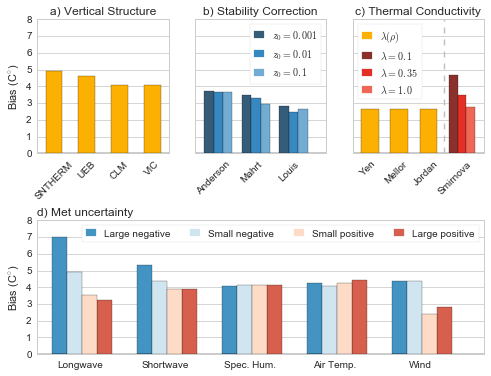

In [81]:
sns.set_context('paper', font_scale=1.25)

# ----------
# Biases
flag_modelRelative = False
s = 'SWA'
ylims = [0, 8]

# Bias relative to model with no errors
if flag_modelRelative:
    noBias = results[s].sel(expID='jrdn1991')
    ds = ((results[s].scalarSurfaceTemp) - noBias.scalarSurfaceTemp)
    ds = ds.where((results[s].scalarSWE > 0) & (noBias.scalarSWE > 0))
    ds = xr.ufuncs.fabs(ds).mean(dim='time')
# Bias relative to observations
else:
    ds = ((results[s].scalarSurfaceTemp - 273.15) - force[s].Tsrf)
    ds = ds.where((force[s].SP) & (results[s].scalarSWE > 0))
    ds = xr.ufuncs.fabs(ds).mean(dim='time')

# Figure
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 3, hspace=0.5)    
width = 0.175

# ----------
# Met Uncertainty
ax = plt.subplot(gs[1, :])
zorder = [1, 2, 4, 3]
ax_x_label = ['Longwave', 'Shortwave', 'Spec. Hum.',
              'Air Temp.', 'Wind']
for n, exp in enumerate(expMetUnc):
    for nameNum, names in enumerate(sorted(expNames[exp], key=sortFun)):
        xpos = ((nameNum + 1) * width) + n
        ax.bar(xpos, np.mean(ds.sel(expID=names)),
               width=width, color=sns.color_palette('RdBu_r', 4)[nameNum], zorder=zorder[nameNum])
ax.set_ylabel('Bias (C$^{\circ}$)')
ax.set_xticks(np.arange(0, len(expNames[exp]) + 1) + 0.5)
ax.set_xticklabels(ax_x_label)
ax.set_xlim(0, 5.25)
ax.xaxis.grid(False)
ax.plot([0, 6], [0, 0], 'k', zorder=1)
ax.set_ylim(ylims)
ax.set_title('d) Met uncertainty', loc='left')

# ----------
# Structural Uncertainty
n = 0
exp = 'layers'
ax = plt.subplot(gs[0, n])
width = 0.5
for nameNum, names in enumerate(expNames[exp]):
    ax.bar(nameNum + width / 2, np.mean(ds.sel(expID=names)),
           width=width, color=sns.xkcd_rgb['yellow orange'])

if ax.is_first_col():
    ax.set_ylabel('Bias (C$^{\circ}$)')
ax.plot([-15, 15], [0, 0], 'k', zorder=0)
ax.set_ylim(ylims)
ax.set_xlim(0, 4)
ax.set_xticks(np.arange(0.5, 4.5))
ax.xaxis.grid(False)
ax.set_xticklabels(internalLabels[exp].values(), rotation=45)
ax.set_title(internalTitles[exp])

# ----------
# Stability corrections
n = 1
exp = 'stability'
ax = plt.subplot(gs[0, n])
array_z0 = ['Low', 'Mid', 'High']
arrayStabSchemes = ['standard', 'louisinv', 'mahrtexp']
width = 0.25
for stabNum, stab in enumerate(arrayStabSchemes):
    for nz, z0 in enumerate(array_z0):
        names= stab + '_' + z0
        xpos = ((nz + 1) * width) + stabNum
        ax.bar(xpos, np.mean(ds.sel(expID=names)),
               width=width, color=sns.color_palette('Blues_d', 3)[nz])

if ax.is_first_col():
    ax.set_ylabel('Bias (C$^{\circ}$)')
ax.plot([-15, 15], [0, 0], 'k', zorder=0)
ax.set_ylim(ylims)
ax.set_yticklabels('')
ax.set_xlim(0, 3.5)
ax.set_xticks(np.arange(0.5, 3))
ax.xaxis.grid(False)
ax.set_xticklabels(internalLabels[exp].values(), rotation=45)
ax.set_title(internalTitles[exp])

# ----------
# Thermal conductivity
n = 2
exp = 'thermalCond'
ax = plt.subplot(gs[0, n])
arrayCond = ['tyen1965', 'melr1977', 'jrdn1991', 'smnv2000']
arrayConstantCond = ['Low', 'Mid', 'High']
xlabels = ['Yen', 'Mellor', 'Jordan', 'Smirnova']
width = 0.3
for condNum, cond in enumerate(arrayCond):
    if cond == 'smnv2000':
        for nl, l in enumerate(arrayConstantCond):
            names= cond + '_' + l
            xpos = ((nl + 1) * width) + condNum
            ax.bar(xpos, np.mean(ds.sel(expID=names)),
                   width=width, color=sns.color_palette('Reds_d', 3)[nl])
    else:
        xpos = width + condNum
        ax.bar(xpos, np.mean(ds.sel(expID=names)),
               width=width * 2, color=sns.xkcd_rgb['yellow orange'])
ax.plot([3.125, 3.125], ylims, '--', color='0.75')

if ax.is_first_col():
    ax.set_ylabel('Bias (C$^{\circ}$)')
ax.plot([-15, 15], [0, 0], 'k', zorder=0)
ax.set_ylim(ylims)
ax.set_yticklabels('')
ax.set_xlim(0, 4.5)
ax.set_xticks(np.arange(0.5, 4))
ax.xaxis.grid(False)
ax.set_xticklabels(xlabels, rotation=45)
ax.set_title(internalTitles[exp])

# ----------
# Custom legends
# Met uncertainty
ax = plt.subplot(gs[1, :])
colsche = sns.color_palette('RdBu_r', 4)
groups = ['Large negative','Small negative','Small positive','Large positive']
h1 = [matplotlib.patches.Patch(color=colsche[n], label=gr) \
          for n,gr in enumerate(groups)]
leg = ax.legend(handles=h1, loc='upper right', ncol=4, handlelength=1, frameon=True)

# Stability and z0
ax = plt.subplot(gs[0, 1])
colsche = sns.color_palette('Blues_d', 3)
groups = ['$z_0 = 0.001$', '$z_0 = 0.01$', '$z_0 = 0.1$']
h1 = [matplotlib.patches.Patch(color=colsche[n], label=gr) \
          for n,gr in enumerate(groups)]
leg = ax.legend(handles=h1, loc='upper right', ncol=1, handlelength=1, frameon=True, columnspacing=1)

# Thermal Conductivity
ax = plt.subplot(gs[0, 2])
colsche = sns.color_palette('Reds_d', 3)
groups = ['$\lambda = 0.1$', '$\lambda = 0.35$', '$\lambda = 1.0$']
h1 = [matplotlib.patches.Patch(color=colsche[n], label=gr) \
          for n,gr in enumerate(groups)]
h1.append(matplotlib.patches.Patch(color=sns.xkcd_rgb['yellow orange'], label=r'$\lambda ( \rho )$'))
h1.insert(0, h1.pop())
leg = ax.legend(handles=h1, loc='upper left', ncol=1, handlelength=1, frameon=True, columnspacing=1)

os.chdir(dirPrint)
fig.savefig(s + '.all.MAE_Ts.bar.pdf')

### Log accuracy ratio

$ ln Q = ln{\frac{x_i}{y_i}}$  

Interpretation is a symmetric error measure that when used for linear regressions more accurately estimate the geometric mean of data than $RMSE$ and Mean Absoluate Percentage Error.

"If the data appears to have a multiplicative error, that is, is
heteroscedastic, then use Σ (ln Q)2 to select your prediction method."

Some other notes:
- It appears like I need to take the mean $ln(Q)^2$ rather than the sum of that quantity. If I don't do this I end up with accuracy ratios that are absurdly large and meaningless for interpretation.
- I don't know how to interpret this quantity. It may be unbiased, but its physical interpretation is not clear

In [92]:
ds = (np.log((results[s].scalarSurfaceTemp - 273.15) / force[s].Tsrf) ** 2)
ds = ds.where((force[s].SP) & (results[s].scalarSWE > 0))
ds = ds.mean(dim='time')
print(ds)

<xarray.DataArray (expID: 45)>
array([ 1.812149,  2.019901,  2.412395,  2.893299,  1.515594,  1.83367 ,
        2.456205,  3.023566,  1.917737,  2.049883,  2.308178,  2.508624,
        1.507612,  1.8428  ,  2.529662,  2.847459,  2.622978,  2.58761 ,
        1.744975,  1.606359,  2.066721,  2.19497 ,  2.11297 ,  2.080925,
        2.177184,  2.177184,  2.177184,  2.076767,  2.076767,  2.076767,
        2.080925,  2.080925,  2.080925,  1.97718 ,  2.240593,  1.792725,
        2.057001,  1.782791,  1.541307,  1.97718 ,  1.659618,  1.365647,
        1.926588,  1.532156,  1.257345])
Coordinates:
    exp      (expID) object 'longwaveBias' 'longwaveBias' 'longwaveBias' ...
    family   (expID) object 'lowLW' 'lowLW' 'highLW' 'highLW' 'lowSW' ...
  * expID    (expID) object 'lowLW_L' 'lowLW_S' 'highLW_S' 'highLW_L' ...


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater
  if not reflexive


//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater
  if not reflexive


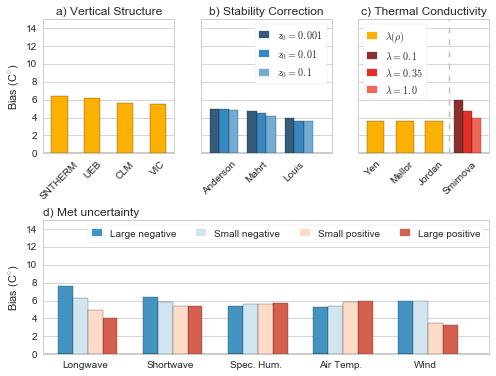

In [95]:
sns.set_context('paper', font_scale=1.25)

# ----------
# Biases
flag_modelRelative = False
s = 'SWA'
ylims = [0, 15]

# Bias relative to model with no errors
if flag_modelRelative:
    noBias = results[s].sel(expID='jrdn1991')
    ds = ((results[s].scalarSurfaceTemp) - noBias.scalarSurfaceTemp)
    ds = ds.where((results[s].scalarSWE > 0) & (noBias.scalarSWE > 0))
    ds = ds.std(dim='time')
# Bias relative to observations
else:
    ds = ((results[s].scalarSurfaceTemp - 273.15) - force[s].Tsrf)
    ds = ds.where((force[s].SP) & (results[s].scalarSWE > 0))
    ds = ds.std(dim='time')

# Figure
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 3, hspace=0.5)    
width = 0.175

# ----------
# Met Uncertainty
ax = plt.subplot(gs[1, :])
zorder = [1, 2, 4, 3]
ax_x_label = ['Longwave', 'Shortwave', 'Spec. Hum.',
              'Air Temp.', 'Wind']
for n, exp in enumerate(expMetUnc):
    for nameNum, names in enumerate(sorted(expNames[exp], key=sortFun)):
        xpos = ((nameNum + 1) * width) + n
        ax.bar(xpos, np.mean(ds.sel(expID=names)),
               width=width, color=sns.color_palette('RdBu_r', 4)[nameNum], zorder=zorder[nameNum])
ax.set_ylabel('Bias (C$^{\circ}$)')
ax.set_xticks(np.arange(0, len(expNames[exp]) + 1) + 0.5)
ax.set_xticklabels(ax_x_label)
ax.set_xlim(0, 5.25)
ax.xaxis.grid(False)
ax.plot([0, 6], [0, 0], 'k', zorder=1)
ax.set_ylim(ylims)
ax.set_title('d) Met uncertainty', loc='left')

# ----------
# Structural Uncertainty
n = 0
exp = 'layers'
ax = plt.subplot(gs[0, n])
width = 0.5
for nameNum, names in enumerate(expNames[exp]):
    ax.bar(nameNum + width / 2, np.mean(ds.sel(expID=names)),
           width=width, color=sns.xkcd_rgb['yellow orange'])

if ax.is_first_col():
    ax.set_ylabel('Bias (C$^{\circ}$)')
ax.plot([-15, 15], [0, 0], 'k', zorder=0)
ax.set_ylim(ylims)
ax.set_xlim(0, 4)
ax.set_xticks(np.arange(0.5, 4.5))
ax.xaxis.grid(False)
ax.set_xticklabels(internalLabels[exp].values(), rotation=45)
ax.set_title(internalTitles[exp])

# ----------
# Stability corrections
n = 1
exp = 'stability'
ax = plt.subplot(gs[0, n])
array_z0 = ['Low', 'Mid', 'High']
arrayStabSchemes = ['standard', 'louisinv', 'mahrtexp']
width = 0.25
for stabNum, stab in enumerate(arrayStabSchemes):
    for nz, z0 in enumerate(array_z0):
        names= stab + '_' + z0
        xpos = ((nz + 1) * width) + stabNum
        ax.bar(xpos, np.mean(ds.sel(expID=names)),
               width=width, color=sns.color_palette('Blues_d', 3)[nz])

if ax.is_first_col():
    ax.set_ylabel('Bias (C$^{\circ}$)')
ax.plot([-15, 15], [0, 0], 'k', zorder=0)
ax.set_ylim(ylims)
ax.set_yticklabels('')
ax.set_xlim(0, 3.5)
ax.set_xticks(np.arange(0.5, 3))
ax.xaxis.grid(False)
ax.set_xticklabels(internalLabels[exp].values(), rotation=45)
ax.set_title(internalTitles[exp])

# ----------
# Thermal conductivity
n = 2
exp = 'thermalCond'
ax = plt.subplot(gs[0, n])
arrayCond = ['tyen1965', 'melr1977', 'jrdn1991', 'smnv2000']
arrayConstantCond = ['Low', 'Mid', 'High']
xlabels = ['Yen', 'Mellor', 'Jordan', 'Smirnova']
width = 0.3
for condNum, cond in enumerate(arrayCond):
    if cond == 'smnv2000':
        for nl, l in enumerate(arrayConstantCond):
            names= cond + '_' + l
            xpos = ((nl + 1) * width) + condNum
            ax.bar(xpos, np.mean(ds.sel(expID=names)),
                   width=width, color=sns.color_palette('Reds_d', 3)[nl])
    else:
        xpos = width + condNum
        ax.bar(xpos, np.mean(ds.sel(expID=names)),
               width=width * 2, color=sns.xkcd_rgb['yellow orange'])
ax.plot([3.125, 3.125], ylims, '--', color='0.75')

if ax.is_first_col():
    ax.set_ylabel('Bias (C$^{\circ}$)')
ax.plot([-15, 15], [0, 0], 'k', zorder=0)
ax.set_ylim(ylims)
ax.set_yticklabels('')
ax.set_xlim(0, 4.5)
ax.set_xticks(np.arange(0.5, 4))
ax.xaxis.grid(False)
ax.set_xticklabels(xlabels, rotation=45)
ax.set_title(internalTitles[exp])

# ----------
# Custom legends
# Met uncertainty
ax = plt.subplot(gs[1, :])
colsche = sns.color_palette('RdBu_r', 4)
groups = ['Large negative','Small negative','Small positive','Large positive']
h1 = [matplotlib.patches.Patch(color=colsche[n], label=gr) \
          for n,gr in enumerate(groups)]
leg = ax.legend(handles=h1, loc='upper right', ncol=4, handlelength=1, frameon=True)

# Stability and z0
ax = plt.subplot(gs[0, 1])
colsche = sns.color_palette('Blues_d', 3)
groups = ['$z_0 = 0.001$', '$z_0 = 0.01$', '$z_0 = 0.1$']
h1 = [matplotlib.patches.Patch(color=colsche[n], label=gr) \
          for n,gr in enumerate(groups)]
leg = ax.legend(handles=h1, loc='upper right', ncol=1, handlelength=1, frameon=True, columnspacing=1)

# Thermal Conductivity
ax = plt.subplot(gs[0, 2])
colsche = sns.color_palette('Reds_d', 3)
groups = ['$\lambda = 0.1$', '$\lambda = 0.35$', '$\lambda = 1.0$']
h1 = [matplotlib.patches.Patch(color=colsche[n], label=gr) \
          for n,gr in enumerate(groups)]
h1.append(matplotlib.patches.Patch(color=sns.xkcd_rgb['yellow orange'], label=r'$\lambda ( \rho )$'))
h1.insert(0, h1.pop())
leg = ax.legend(handles=h1, loc='upper left', ncol=1, handlelength=1, frameon=True, columnspacing=1)

os.chdir(dirPrint)
fig.savefig(s + '.all.RMSE_Ts.bar.pdf')

Using the RMSE does not seem to give any further physical insights and largely just mirrors the MAE, suggesting that the model response is largely determined by uniform offsets in Ts, rather than a change in variance.